In [ ]:
import kmodels as kmk
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch
os.getcwd()

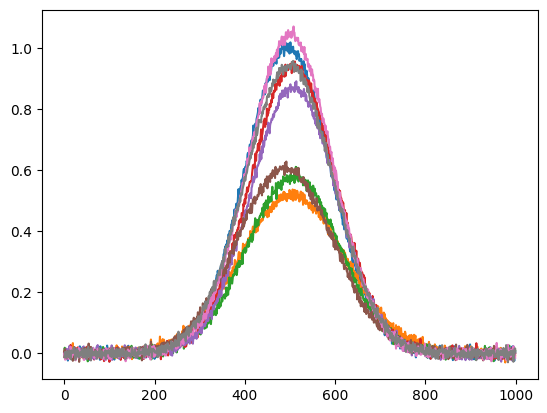

In [27]:
# create a standard LSTM that will accept 8 featues and output 1 prediction. The LSTM will have 32 hidden layers. We are regressing the force produced from 8 EMG sensors. Thus the output and input are
# time series data. There will also be a single linear layer at the end of the LSTM to produce the output.

class test_lstm(nn.Module):
    def __init__(self):
        super(test_lstm, self).__init__()
        self.lstm = nn.LSTM(input_size=8, hidden_size=32, num_layers=1, batch_first=True)
        self.linear = nn.Linear(32, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# test the model

# create a time series of a gaussian sigmal with 8 features. make the gaussian signal have a peak at t_mu and a width of t_sigma. The gaussian signal will be the same for all 8 features. For each feature we will add a random 
# number to the t_mu and t_sigma. This will create a time series of 8 features that are all correlated with each other. 
x = np.linspace(0, 100, 1000)
gau_signals = []
t_mu = 50
for i in range(8):
    t_mu += np.random.normal(0, 1)
    t_sigma = 10 + np.random.normal(0, 1)
    # create a prefactor that varies from 0.8-1.2
    A = 0.8 + np.random.normal(0, 0.2)
    noise = np.random.normal(0, 0.1, 1000)*0.1
    gau_signals.append(A * np.exp(-((x - t_mu)**2 / (2 * t_sigma**2))) + noise)

# plot
for i in range(8):
    plt.plot(gau_signals[i])

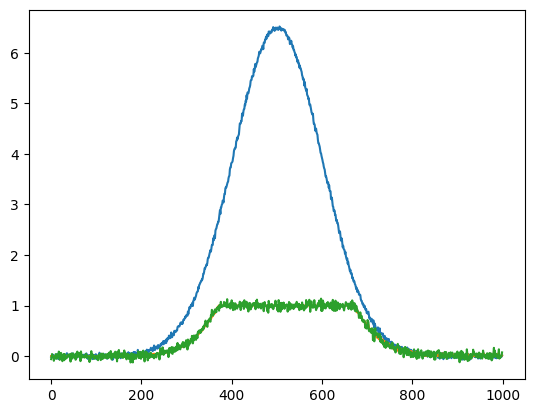

In [37]:
# make the force output signal by correlating a linear ramping function with the gaussian signals. add a time delay to the force signal. make the signal saturate at 1.0
y = []
gau_sum = np.sum(gau_signals, axis=0)
plt.plot(gau_sum)
force = np.linspace(0, 1, 1000)
force = force * gau_sum
# the force should saturate at 1
force = np.clip(force, 0, 1)
plt.plot(force)
# add noise to the force signal
force = force + np.random.normal(0, 0.1, 1000)*0.5
plt.plot(force)


In [45]:
# lets make a subject class that will store the arrays for the time series data. 
# the subject class will also have a method to create a dataset from the time series data.
# we will later use this class to efficeintly produce a fake dataset for testing the model. 

class subject():
    def __init__(self, time, t_mu=50, t_sigma=10):
        # generate the fake EMG signals 
        EMGS = []
        self.t_mu = t_mu
        self.t_sigma = t_sigma
        for i in range(8):
            t_mu += np.random.normal(0, 1)
            t_sigma = 10 + np.random.normal(0, 1)
            # create a prefactor that varies from 0.8-1.2
            A = 0.8 + np.random.normal(0, 0.2)
            noise = np.random.normal(0, 0.1, 1000)*0.1
            EMGS.append(A * np.exp(-((time - t_mu)**2 / (2 * t_sigma**2))) + noise)
        
        # make the force output signal by correlating a linear ramping function with the gaussian signals. add a time delay to the force signal. make the signal saturate at 1.0
        gau_sum = np.sum(EMGS, axis=0)
        force = np.linspace(0, 1, 1000)
        force = force * gau_sum
        force = np.clip(force, 0, 1)
        force = force + np.random.normal(0, 0.1, 1000)*0.5
        force = force.reshape(-1, 1)
        self.EMGS = EMGS
        self.force = force
        return

    def get_force(self):
        return self.force
    def get_EMG(self):
        return self.EMGS
    
    def make_dataset(self, EMGS, force, window_size=100, stride=10):
        # create a dataset from the EMG signals and the force signal
        # the dataset will be a list of tuples. Each tuple will be a window of EMG signals and a window of force signals.
        # the window size and stride will be used to create the windows
        dataset = []
        for i in range(0, len(EMGS[0]) - window_size, stride):
            EMG_window = []
            for j in range(8):
                EMG_window.append(EMGS[j][i:i+window_size])
            force_window = force[i:i+window_size]
            dataset.append((EMG_window, force_window))
        return dataset


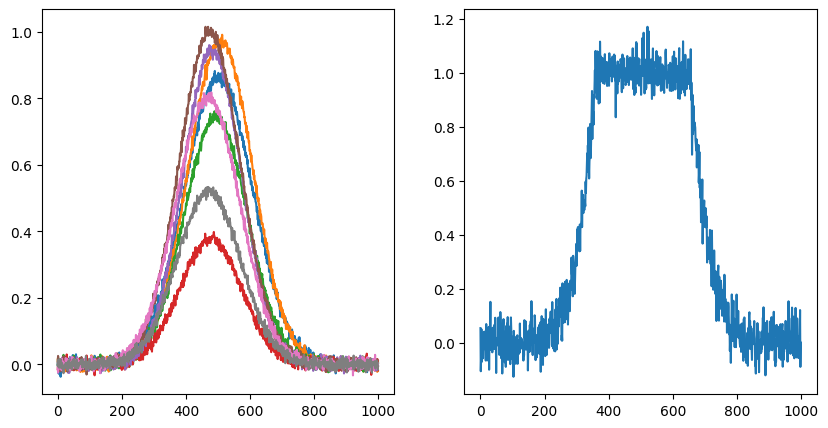

In [64]:
time = np.linspace(0, 100, 1000)
s = subject(time)

# create a dataset from the subject class
data = s.make_dataset(s.EMGS, s.force, window_size=100, stride=10)

# plot x in the left panel and y in the right panel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(8):
    axs[0].plot(s.EMGS[i])

axs[1].plot(s.force)


In [70]:

scaler = StandardScaler()
# create a dataset from the subject class
data = s.make_dataset(s.EMGS, s.force, window_size=100, stride=10)

# create a list of tensors for the EMG signals and a list of tensors for the force signals

X = [torch.tensor(x[0]) for x in data]
Y = [torch.tensor(x[1]) for x in data]


In [77]:
model(X[0])


RuntimeError: mat1 and mat2 must have the same dtype

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([999])) that is different to the input size (torch.Size([999, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.4996, grad_fn=<MseLossBackward0>)
tensor(0.4977, grad_fn=<MseLossBackward0>)
tensor(0.4977, grad_fn=<MseLossBackward0>)
tensor(0.4977, grad_fn=<MseLossBackward0>)
tensor(0.4977, grad_fn=<MseLossBackward0>)


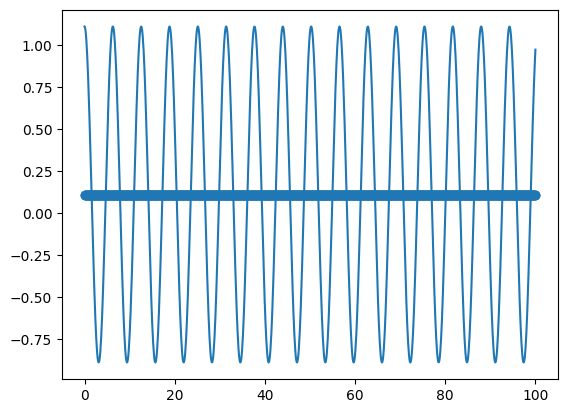

In [22]:
# create fake data for the lstm
T = np.linspace(0, 100, 1000)  
x = np.sin(T) + np.random.randn(1) * 0.1
y = np.cos(T) + np.random.randn(1) * 0.1
scaler = StandardScaler()
x = scaler.fit_transform(x.reshape(-1, 1))
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
model = LSTM()

# train the model
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

for i in range(500):
    opt.zero_grad()
    preds = model(x)
    # preds.shape is (1000, 1)
    # x.shape is (1000, 1)
    # we need to remove the last prediction from preds and the first value from x
    # to get the same shape
    loss_val = loss(preds[:-1], y[1:])
    loss_val.backward()
    opt.step()
    if i % 100 == 0:
        print(loss_val)
        
# plot the results
plt.plot(T, y, label='input')
plt.scatter(T, preds.detach().numpy(), label='preds')

In [ ]:
data_path = '../../data/'
# get all pickles
pickles = [f for f in os.listdir(data_path) if f.endswith('.pkl')]
# get the Formatted pickle
data = [f for f in pickles if 'Formatted' in f][0]
df = pd.read_pickle(data_path + data)
df

In [ ]:
xcols = df.columns
# drop "ADD", and "Subject"
xcols = list(xcols.drop(['ADD', 'Subject']))
ycols = ['Fx','Fy','Fz']
# drop all the ycols from xcols
xcols = list(set(xcols) - set(ycols))
print(xcols)
print(ycols)
# lets normalize all the xcols data and put it back in the dataframe
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df[xcols])
df[xcols] = x_scaled

In [ ]:
#random_search_results = kmk.random_search(df, batch_size=10000, n_epochs=11, n_iter=10, n_splits=5)

In [ ]:
#random_search_results[1]

In [ ]:
model = kmk.NN(layer_size=50, layers=3, n_inputs=len(xcols), n_outputs=len(ycols))

In [ ]:
data = kmk.Dataset(df, sort_column=['Subject'])


In [ ]:
exp_df = pd.read_pickle('../../data/SeparatedData.pkl')
exp_data = kmk.Dataset(exp_df, sort_column=['Subject'])
exp_data.X_lstm.shape, exp_data.Y_lstm.shape, exp_data.Y_lstm[0].shape

In [ ]:
# create a lstm with pytorch. the inputs should have lstom_layers=3, n_inputs=len(xcols), n_outputs=len(ycols) and n_timesteps=exp_data.X_lstm.shape[1], linear_layers=3, 
# linear_layer_size=50. create the entire model with the __init__ function, and then create the forward function.

class LSTM(nn.Module):
    def __init__(self, n_lstm_layers=3, n_lstm_outputs=50, 
                 lstm_hidden_size=3, n_inputs=8, n_outputs=3, 
                 n_timesteps=204, n_linear_layers=1, linear_layer_size=50):
        super(LSTM, self).__init__()
        self.lstm_layers = n_lstm_layers
        self.n_lstm_hidden_size = lstm_hidden_size
        self.n_lstm_outputs = n_lstm_outputs
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_timesteps = n_timesteps
        self.n_linear_layers = n_linear_layers
        self.linear_layer_size = linear_layer_size
        self.lstm_output_dim = n_timesteps*n_lstm_layers
        
        self.lstm = nn.LSTM(input_size=n_inputs, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=n_lstm_layers)
        
        self.linear_layers = nn.ModuleList()
        self.first_linear_layer = nn.Linear(self.lstm_output_dim, linear_layer_size)
        for i in range(n_linear_layers):
            self.linear_layers.append(nn.Linear(linear_layer_size, linear_layer_size))
        self.output_layer = nn.Linear(linear_layer_size, n_outputs*self.n_timesteps)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        # make sure x in flattened
        x = x.flatten()
        x = self.first_linear_layer(x)
        for layer in self.linear_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x.reshape(self.n_timesteps, self.n_outputs)
    
model = LSTM()
test = torch.tensor(exp_data.X_lstm[0:1])
model(test)

In [ ]:
losses = kmk.run_Pytorch(model, data.X_lstm, data.Y_lstm, n_epochs=21, batch_size=1, learning_rate=1e-4)

In [ ]:
def TLLSTM(model, X, change_layers=1):
    new = LSTM(n_lstm_layers=model.lstm_layers, n_lstm_outputs=model.n_lstm_outputs,
               lstm_hidden_size=model.n_lstm_hidden_size, n_inputs=model.n_inputs,
               n_timesteps=model.n_timesteps, n_linear_layers=model.n_linear_layers,
               linear_layer_size=model.linear_layer_size)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    for i in range(change_layers):
        layer = children[total_layers-i-1]
        layer_params = layer.parameters()
        for p in layer_params:
            p.requires_grad = True
    return new



In [ ]:
tl_model = TLLSTM(model, test, change_layers=1)
tl_model

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
pred = model(data.X_lstm.to('cuda')).detach().cpu().numpy()
pred[:,0].shape, data.Y[:,0].shape

In [ ]:
x_1 = data.X[data.subject_index[0]]
plt.plot(x_1[0:204,0], x_1[0:204,1])

In [ ]:
X = data.X.float()
Y = data.Y.float()

# use a scaler to scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.from_numpy(X).float()
X.shape

In [ ]:
plt.plot(X[0:300,0], X[0:300,1])

In [ ]:
losses = kmk.run_Pytorch(model, X, Y, batch_size=len(X)/2, n_epochs=251, learning_rate=1e-3,
                         optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2))


In [ ]:
plt.plot(losses)

In [ ]:
tlm = kmk.TLNN(model, X[0:2, :], change_layers=1)


In [ ]:
df2 = pd.read_pickle('../../data/SeparatedData.pkl')
df2

In [ ]:
print([i for i in df.columns if i in xcols])
print(xcols)
exp_data = kmk.Dataset(df2, sort_column=['Subject'])
n_subjects = len(exp_data.subjects)

test_data = exp_data.X[(n_subjects-1)*900:, :]
test_labels = exp_data.Y[(n_subjects-1)*900:, :]


train_data= exp_data.X[0:(n_subjects-1)*900, :]
train_labels = exp_data.Y[0:(n_subjects-1)*900, :]
train_data = train_data.float()
train_labels = train_labels.float()
# scale the data
train_data = train_data.detach().cpu().numpy()
train_data = scaler.transform(train_data)
train_data = torch.from_numpy(train_data).float()

In [ ]:
exp_data.X.shape

In [ ]:
tlm_losses = kmk.run_Pytorch(tlm, train_data, train_labels, learning_rate=1e-3, 
                             batch_size=32, n_epochs=1001, 
                             optimizer=torch.optim.Adam(tlm.parameters(), lr=1e-3, weight_decay=1e-1))


In [ ]:
# parity plot
pred = tlm(test_data.float().to('cuda'))
plt.scatter(pred.detach().cpu().numpy()[:,0], test_labels.detach().cpu().numpy()[:,0])
r2 = kmk.r2_score(pred.detach().cpu().numpy()[:,0], test_labels.detach().cpu().numpy()[:,0])
mae = kmk.mean_absolute_error(pred.detach().cpu().numpy()[:,0], test_labels.detach().cpu().numpy()[:,0])
mse = kmk.mean_squared_error(pred.detach().cpu().numpy()[:,0], test_labels.detach().cpu().numpy()[:,0])
print('r2: ', r2)
print('mae: ', mae)
print('mse: ', mse)

In [ ]:
# random forest for comparison
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=0, n_jobs=-1)
reg.fit(train_data.detach().cpu().numpy(), train_labels.detach().cpu().numpy())
pred = reg.predict(test_data.detach().cpu().numpy())
# parity plot
plt.scatter(pred[:,0], test_labels.detach().cpu().numpy()[:,0])
# print out all the stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 = r2_score(test_labels.detach().cpu().numpy(), pred)
mae = mean_absolute_error(test_labels.detach().cpu().numpy(), pred)
mse = mean_squared_error(test_labels.detach().cpu().numpy(), pred)
print('R2: ', r2)
print('MAE', mae)
print('MSE', mse)

In [ ]:
# lets try a linear model
# grab the x data for the first subject
x, y = kmk.Dataset(df2, sort_column=['Subject'])[0]
# sort x and y by the time column
time = x[:,0]
x = x[time.argsort()]
y = y[time.argsort()]
plt.plot(x[:,0], y[:,0])
plt.plot(x[:,0], y[:,1])
plt.plot(x[:,0], y[:,2])

# lets plot the predictions from the tlm model
x_1 = scaler.transform(x)
pred_1 = tlm(torch.from_numpy(x_1).float().to('cuda')).detach().cpu().numpy()
x_1 = scaler.inverse_transform(x_1)
plt.plot(x[:,0], pred_1[:,0],alpha=0.5)
plt.plot(x[:,0], pred_1[:,1],alpha=0.5)
plt.plot(x[:,0], pred_1[:,2],alpha=0.5)